In [100]:
import re
from tqdm.notebook import tqdm
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path 

In [101]:
# Import and configure seaborn

import seaborn as sns # <--
sns.set_style("darkgrid") # Load darkgrid theme
sns.set_context("paper") # Use big fonts

#Options
params = {
    'text.usetex' : True,
    'pgf.texsystem': 'pdflatex',
    'pgf.rcfonts': False,
    'font.family': 'serif',
    'font.serif': ['Times'],
    'font.size' : 10,
    'axes.labelsize': 9,
    'legend.fontsize': 9,
    'legend.title_fontsize': 9,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9
    }

sns.set(font_scale=1, rc=params)

#plt.rcParams.update(params)

In [102]:
PROCS=16
SIZE=4096

overhead_data = pd.DataFrame(columns=['binary', 'rank', 'calc_time', 'mpi_time'])

# p = re.compile(".\/[0-9]{4}(?:-[0-9]{2}){2}_[0-9]{2}(?:-[0-9]{2}){2}-(\w+)\/.*")
p = re.compile("Overhead_([0-9a-zA-Z_]+)")

for libscibench in tqdm(glob("./Overhead_*/202*/P" + str(PROCS) + "-D" + str(SIZE) + "/job.log"), unit='Files'):
    # print(libscibench)

    res = p.search(libscibench)
    binary_name = res.group(1)

    state = 0
    parse_count = 0
    with open(libscibench, 'r') as handle:
        for linenumber, line in enumerate(handle, 0):
            if parse_count >= PROCS:
                break
            if state == 0 and "***** LSB_Init" in line:
                state = 1
            elif state == 1:
                splt_str = line.replace(',', '').replace('\n', '').split(' ')
                vals = [binary_name, int(splt_str[2]), float(splt_str[5]), float(splt_str[8])]
                # print(vals)

                # temp_df = pd.DataFrame(vals, columns=['rank', 'calc_time', 'mpi_time'])
                val_series = pd.Series(vals, index = overhead_data.columns)

                overhead_data = overhead_data.append(val_series, ignore_index=True)

                # pd.DataFrame(np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]]),
                #    columns=['a', 'b', 'c'])
                parse_count += 1

overhead_data['binary'] = pd.Categorical(overhead_data['binary'], ["Blocked_Size_1", "Blocked_Size_Optimal"])
overhead_data = overhead_data.sort_values(["binary", "rank"])

print(overhead_data)

  0%|          | 0/2 [00:00<?, ?Files/s]

                  binary rank     calc_time      mpi_time
31        Blocked_Size_1    0  1.270083e+06  2.902693e+07
16        Blocked_Size_1    1  1.047692e+06  3.427149e+07
17        Blocked_Size_1    2  1.049445e+06  2.526722e+07
18        Blocked_Size_1    3  1.040311e+06  3.227357e+07
19        Blocked_Size_1    4  1.041822e+06  3.424090e+07
20        Blocked_Size_1    5  1.042760e+06  3.423673e+07
21        Blocked_Size_1    6  1.041973e+06  3.426908e+07
22        Blocked_Size_1    7  1.039406e+06  3.426975e+07
23        Blocked_Size_1    8  1.042895e+06  2.827148e+07
24        Blocked_Size_1    9  1.035323e+06  2.827649e+07
25        Blocked_Size_1   10  9.554674e+05  3.334824e+07
26        Blocked_Size_1   11  9.488584e+05  3.432816e+07
27        Blocked_Size_1   12  9.489015e+05  3.236362e+07
28        Blocked_Size_1   13  9.474555e+05  3.236192e+07
29        Blocked_Size_1   14  9.544949e+05  3.436548e+07
30        Blocked_Size_1   15  9.521343e+05  3.432367e+07
15  Blocked_Si

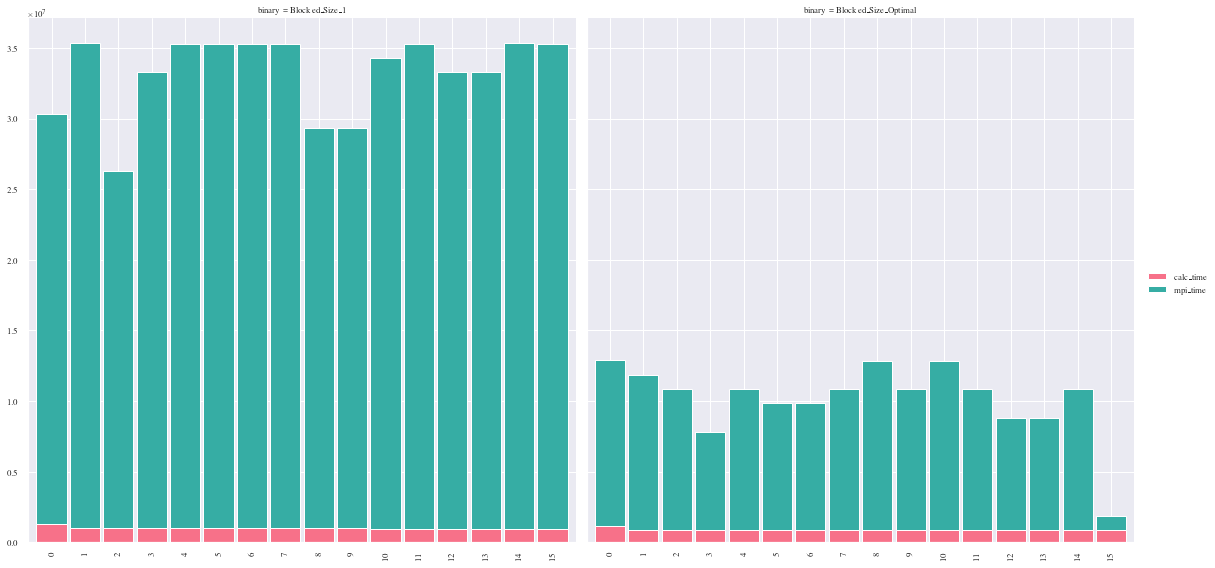

In [103]:
def facet(data, color):
    f = data.set_index('rank').plot.bar(stacked=True, ax=plt.gca(), color=sns.husl_palette(n_colors=2), width=0.9)
    f.set_xlabel("")

g = sns.FacetGrid(overhead_data, col="binary", height=8, sharex=False, sharey=True)
g = g.map_dataframe(facet)
g.add_legend()


OUTPUT_FOLDER = "../../dphpc-report/graphs/pipeline"
export_to = Path(f"{OUTPUT_FOLDER}/overhead/")
export_to.mkdir(parents=True, exist_ok=True)
plt.savefig(f"{export_to.resolve()}/mpi-overhead-cholesky.png", bbox_inches='tight')
plt.savefig(f"{export_to.resolve()}/mpi-overhead-cholesky.eps", bbox_inches='tight')

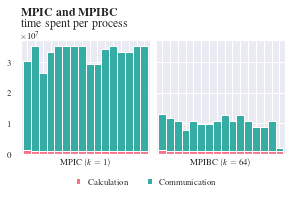

In [104]:
ASPECT_RATIO = 4/2

fig, axes = plt.subplots(1, 2, sharey=True, figsize=(LINE_WIDTH*1.2,LINE_WIDTH*1.2/ASPECT_RATIO), constrained_layout=True)

titles = ["MPIC $(k=1)$", "MPIBC $(k=64)$"]

axes_index = 0

for label, data in overhead_data.groupby("binary"):
    f = data.set_index('rank').plot.bar(stacked=True, ax=axes[axes_index], color=sns.husl_palette(n_colors=2), width=1, legend=False)
    f.set_xlabel(titles[axes_index])
    f.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    
    axes_index+=1

fig.legend(labels=["Calculation", "Communication"], loc='upper center', bbox_to_anchor=(0.5, 0.0), ncol=2, frameon=False, handlelength=0.5)
plt.suptitle(r"\textbf{MPIC and MPIBC}" + "\ntime spent per process", y=1.15, x=0.06, horizontalalignment='left')


OUTPUT_FOLDER = "../../dphpc-report/graphs/pipeline"
export_to = Path(f"{OUTPUT_FOLDER}/overhead/")
export_to.mkdir(parents=True, exist_ok=True)
plt.savefig(f"{export_to.resolve()}/mpi-overhead-cholesky.png", bbox_inches='tight')
plt.savefig(f"{export_to.resolve()}/mpi-overhead-cholesky.eps", bbox_inches='tight')
